In [ ]:
# based on
# https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html

In [27]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [28]:
# use this to test on hifi data
import numpy as np
# train_x, train_y = np.load("test-lofi.npy")
# train_x, train_y = np.load("test-hifi.npy")
train_x, train_y = np.load("test-bridge.npy")

X = train_x[:, np.newaxis]
Y = train_y[:, np.newaxis]


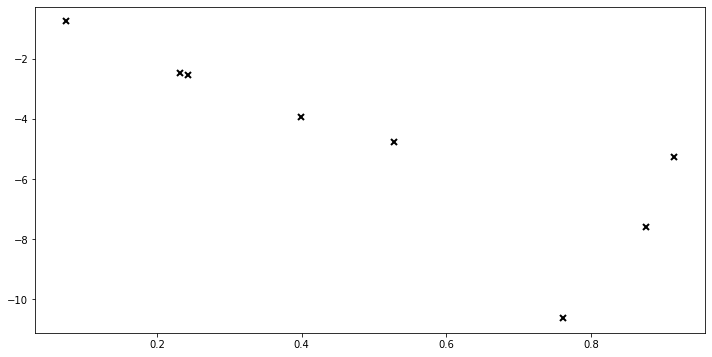

In [29]:
plt.plot(X, Y, "kx", mew=2)

In [30]:
k = gpflow.kernels.Matern52()

In [31]:
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [32]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [33]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [34]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [35]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    0.3  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    0.01 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [36]:
# by default using the L-BFGS-B
opt = gpflow.optimizers.Scipy()

In [37]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 29.4926      │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.277132    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1.06622e-06 │
╘═════════════════════════╧═══════════╧═════════════════

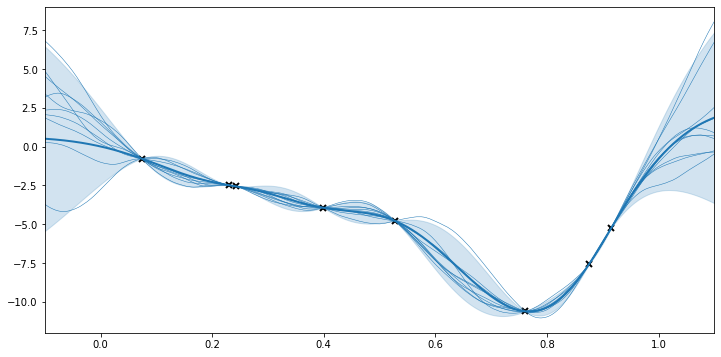

In [38]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 1000).reshape(-1, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)